## Using a custom BoTorch model with Ax

In this tutorial, we illustrate how to use a custom BoTorch model within Ax's `botorch_modular` API. This allows us to harness the convenience of Ax for running Bayesian Optimization loops while maintaining full flexibility in modeling.

Acquisition functions and their optimizers can be swapped out in much the same fashion. See for example the tutorial for [Implementing a custom acquisition function](./custom_acquisition).

If you want to do something non-standard, or would like to have full insight into every aspect of the implementation, please see [this tutorial](./closed_loop_botorch_only) for how to write your own full optimization loop in BoTorch.


In [19]:
import os
from contextlib import contextmanager, nullcontext

from ax.utils.testing.mock import fast_botorch_optimize_context_manager
import plotly.io as pio

# Ax uses Plotly to produce interactive plots. These are great for viewing and analysis,
# though they also lead to large file sizes, which is not ideal for files living in GH.
# Changing the default to `png` strips the interactive components to get around this.
pio.renderers.default = "png"

SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_EVALS = 10 if SMOKE_TEST else 30

### Implementing the custom model

For this tutorial, we implement a very simple GPyTorch `ExactGP` model that uses an RBF kernel (with ARD) and infers a homoskedastic noise level.

Model definition is straightforward. Here we implement a GPyTorch `ExactGP` that inherits from `GPyTorchModel`; together these two superclasses add all the API calls that BoTorch expects in its various modules. 

*Note:* BoTorch allows implementing any custom model that follows the `Model` API. For more information, please see the [Model Documentation](../docs/models).

In [20]:
from typing import Optional

from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from torch import Tensor


class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y, train_Yvar: Optional[Tensor] = None):
        # NOTE: This ignores train_Yvar and uses inferred noise instead.
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

### Instantiate a `BoTorchModel` in Ax

A `BoTorchModel` in Ax encapsulates both the surrogate -- which `Ax` calls a `Surrogate` and BoTorch calls a `Model` -- and an acquisition function. Here, we will only specify the custom surrogate and let Ax choose the default acquisition function.

Most models should work with the base `Surrogate` in Ax, except for BoTorch `ModelListGP`, which works with `ListSurrogate`.
Note that the `Model` (e.g., the `SimpleCustomGP`) must implement `construct_inputs`, as this is used to construct the inputs required for instantiating a `Model` instance from the experiment data.

In [21]:
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate


ax_model = BoTorchModel(
    surrogate=Surrogate(
        # The model class to use
        botorch_model_class=SimpleCustomGP,
        # Optional, MLL class with which to optimize model parameters
        # mll_class=ExactMarginalLogLikelihood,
        # Optional, dictionary of keyword arguments to model constructor
        # model_options={}
    ),
    # Optional, acquisition function class to use - see custom acquisition tutorial
    # botorch_acqf_class=qExpectedImprovement,
)

### Combine with a `ModelBridge`

`Model`s in Ax require a `ModelBridge` to interface with `Experiment`s. A `ModelBridge` takes the inputs supplied by the `Experiment` and converts them to the inputs expected by the `Model`. For a `BoTorchModel`, we use `TorchModelBridge`. The Modular BoTorch interface creates the `BoTorchModel` and the `TorchModelBridge` in a single step, as follows:

```
from ax.modelbridge.registry import Models
model_bridge = Models.BOTORCH_MODULAR(
    experiment=experiment,
    data=data,
    surrogate=Surrogate(SimpleCustomGP),
    # Optional, will use default if unspecified
    # botorch_acqf_class=qLogNoisyExpectedImprovement,  
)
# To generate a trial
trial = model_bridge.gen(1)
```


# Using the custom model in Ax to optimize the Branin function

We will demonstrate this with both the Service API (simpler, easier to use) and the Developer API (advanced, more customizable).

## Optimization with Ax's Service API

A detailed tutorial on the Service API can be found [here](https://ax.dev/tutorials/gpei_hartmann_service.html).

In order to customize the way the candidates are created in the Service API, we need to construct a new `GenerationStrategy` and pass it into `AxClient`.

In [22]:
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models


gs = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=5,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SimpleCustomGP),
            },
        ),
    ]
)

### Setting up the experiment

In order to use the `GenerationStrategy` we just created, we will pass it into the `AxClient`.

In [23]:
import torch
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from botorch.test_functions import Branin


# Initialize the client - AxClient offers a convenient API to control the experiment
ax_client = AxClient(generation_strategy=gs)
# Setup the experiment
ax_client.create_experiment(
    name="branin_test_experiment",
    parameters=[
        {
            "name": "x1",
            "type": "range",
            # It is crucial to use floats for the bounds, i.e., 0.0 rather than 0.
            # Otherwise, the parameter would be inferred as an integer range.
            "bounds": [-5.0, 10.0],
        },
        {
            "name": "x2",
            "type": "range",
            "bounds": [0.0, 15.0],
        },
    ],
    objectives={
        "branin": ObjectiveProperties(minimize=True),
    },
)
# Setup a function to evaluate the trials
branin = Branin()


def evaluate(parameters):
    x = torch.tensor([[parameters.get(f"x{i+1}") for i in range(2)]])
    # The GaussianLikelihood used by our model infers an observation noise level,
    # so we pass an sem value of NaN to indicate that observation noise is unknown
    return {"branin": (branin(x).item(), float("nan"))}

[INFO 02-22 18:21:07] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-22 18:21:07] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-22 18:21:07] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-22 18:21:07] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x1', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x2', parameter_type=FLOAT, range=[0.0, 15.0])], parameter_constraints=[]).


### Running the BO loop

The next cell sets up a decorator solely to speed up the testing of the notebook in `SMOKE_TEST` mode. You can safely ignore this cell and the use of the decorator throughout the tutorial.

In [24]:
if SMOKE_TEST:
    fast_smoke_test = fast_botorch_optimize_context_manager
else:
    fast_smoke_test = nullcontext

# Set a seed for reproducible tutorial output
torch.manual_seed(0)

In [25]:
with fast_smoke_test():
    for i in range(NUM_EVALS):
        parameters, trial_index = ax_client.get_next_trial()
        # Local evaluation here can be replaced with deployment to external system.
        ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 02-22 18:21:07] ax.service.ax_client: Generated new trial 0 with parameters {'x1': 0.62583, 'x2': 14.359564}.
[INFO 02-22 18:21:07] ax.service.ax_client: Completed trial 0 with data: {'branin': (104.365417, nan)}.
[INFO 02-22 18:21:07] ax.service.ax_client: Generated new trial 1 with parameters {'x1': 1.458453, 'x2': 14.529696}.
[INFO 02-22 18:21:07] ax.service.ax_client: Completed trial 1 with data: {'branin': (122.930588, nan)}.
[INFO 02-22 18:21:07] ax.service.ax_client: Generated new trial 2 with parameters {'x1': 9.140571, 'x2': 4.816245}.
[INFO 02-22 18:21:07] ax.service.ax_client: Completed trial 2 with data: {'branin': (7.390774, nan)}.
[INFO 02-22 18:21:07] ax.service.ax_client: Generated new trial 3 with parameters {'x1': 8.215463, 'x2': 9.037606}.
[INFO 02-22 18:21:07] ax.service.ax_client: Completed trial 3 with data: {'branin': (61.271847, nan)}.
[INFO 02-22 18:21:07] ax.service.ax_client: Generated new trial 4 with parameters {'x1': 9.934317, 'x2': 14.913237}.
[INFO

[INFO 02-22 18:21:08] ax.service.ax_client: Generated new trial 5 with parameters {'x1': 7.57319, 'x2': 4.209484}.
[INFO 02-22 18:21:08] ax.service.ax_client: Completed trial 5 with data: {'branin': (20.803038, nan)}.
[INFO 02-22 18:21:09] ax.service.ax_client: Generated new trial 6 with parameters {'x1': -3.439572, 'x2': 5.5828}.
[INFO 02-22 18:21:09] ax.service.ax_client: Completed trial 6 with data: {'branin': (55.87426, nan)}.
[INFO 02-22 18:21:09] ax.service.ax_client: Generated new trial 7 with parameters {'x1': 0.784806, 'x2': 4.631828}.
[INFO 02-22 18:21:09] ax.service.ax_client: Completed trial 7 with data: {'branin': (16.833212, nan)}.
[INFO 02-22 18:21:10] ax.service.ax_client: Generated new trial 8 with parameters {'x1': -5.0, 'x2': 13.098945}.
[INFO 02-22 18:21:10] ax.service.ax_client: Completed trial 8 with data: {'branin': (29.4389, nan)}.
[INFO 02-22 18:21:12] ax.service.ax_client: Generated new trial 9 with parameters {'x1': 10.0, 'x2': 11.773668}.
[INFO 02-22 18:21:1

### Viewing the evaluated trials

In [26]:
ax_client.get_trials_data_frame()

[WARNING 02-22 18:21:31] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,arm_name,trial_status,generation_method,branin,x1,x2
0,0,0_0,COMPLETED,Sobol,104.365417,0.625830,14.359564
1,1,1_0,COMPLETED,Sobol,122.930588,1.458453,14.529696
2,2,2_0,COMPLETED,Sobol,7.390774,9.140571,4.816245
3,3,3_0,COMPLETED,Sobol,61.271847,8.215463,9.037606
4,4,4_0,COMPLETED,Sobol,145.015671,9.934317,14.913237
5,5,5_0,COMPLETED,BoTorch,20.803038,7.573190,4.209484
6,6,6_0,COMPLETED,BoTorch,55.874260,-3.439572,5.582800
7,7,7_0,COMPLETED,BoTorch,16.833212,0.784806,4.631828
8,8,8_0,COMPLETED,BoTorch,29.438900,-5.000000,13.098945
9,9,9_0,COMPLETED,BoTorch,78.868507,10.000000,11.773668


In [27]:
parameters, values = ax_client.get_best_parameters()
print(f"Best parameters: {parameters}")
print(f"Corresponding mean: {values[0]}, covariance: {values[1]}")

Best parameters: {'x1': 9.47611380696309, 'x2': 2.4726957016689757}
Corresponding mean: {'branin': 0.3883132706861332}, covariance: {'branin': {'branin': 0.09879254176300166}}


### Plotting the response surface and optimization progress

[INFO 02-22 18:21:31] ax.service.ax_client: Retrieving contour plot with parameter 'x1' on X-axis and 'x2' on Y-axis, for metric 'branin'. Remaining parameters are affixed to the middle of their range.


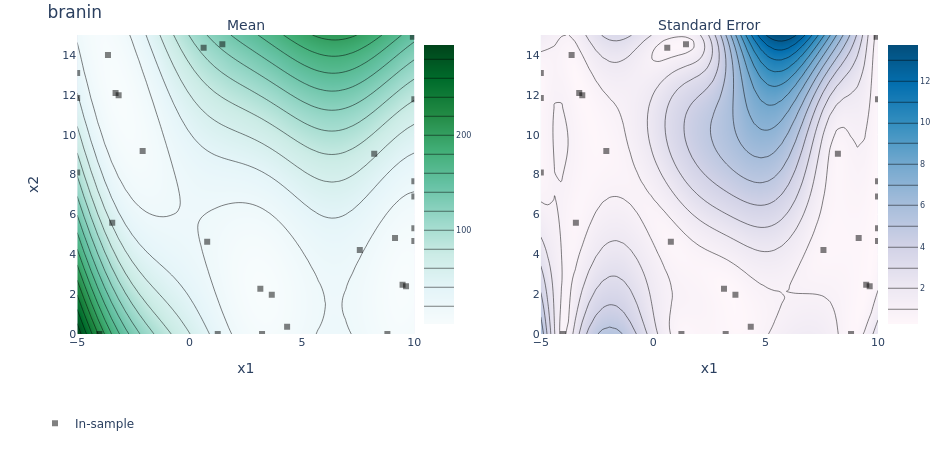

In [28]:
from ax.utils.notebook.plotting import render

render(ax_client.get_contour_plot())

In [29]:
best_parameters, values = ax_client.get_best_parameters()
best_parameters, values[0]

({'x1': 9.47611380696309, 'x2': 2.4726957016689757},
 {'branin': 0.3883132706861332})

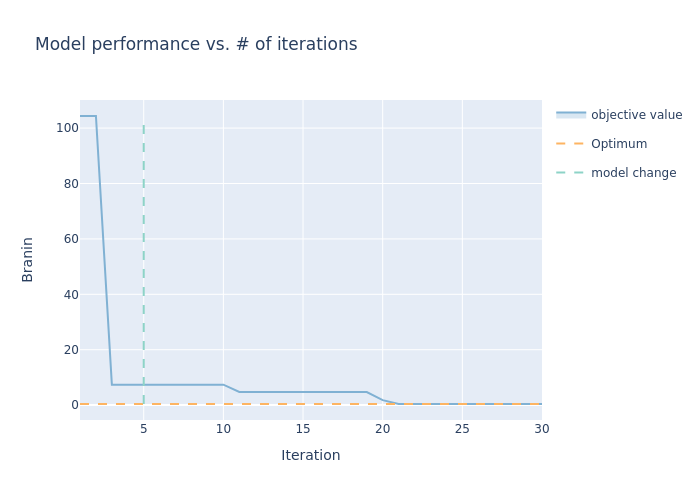

In [30]:
render(ax_client.get_optimization_trace(objective_optimum=0.397887))

## Optimization with the Developer API

A detailed tutorial on the Service API can be found [here](https://ax.dev/tutorials/gpei_hartmann_developer.html).

### Set up the Experiment in Ax

We need 3 inputs for an Ax `Experiment`:
- A search space to optimize over;
- An optimization config specifiying the objective / metrics to optimize, and optional outcome constraints;
- A runner that handles the deployment of trials. For a synthetic optimization problem, such as here, this only returns simple metadata about the trial.

In [31]:
import pandas as pd
import torch
from ax import (
    Data,
    Experiment,
    Metric,
    Objective,
    OptimizationConfig,
    ParameterType,
    RangeParameter,
    Runner,
    SearchSpace,
)
from ax.utils.common.result import Ok
from botorch.test_functions import Branin


branin_func = Branin()

# For our purposes, the metric is a wrapper that structures the function output.
class BraninMetric(Metric):
    def fetch_trial_data(self, trial):
        records = []
        for arm_name, arm in trial.arms_by_name.items():
            params = arm.parameters
            tensor_params = torch.tensor([params["x1"], params["x2"]])
            records.append(
                {
                    "arm_name": arm_name,
                    "metric_name": self.name,
                    "trial_index": trial.index,
                    "mean": branin_func(tensor_params),
                    "sem": float(
                        "nan"
                    ),  # SEM (observation noise) - NaN indicates unknown
                }
            )
        return Ok(value=Data(df=pd.DataFrame.from_records(records)))


# Search space defines the parameters, their types, and acceptable values.
search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name="x1", parameter_type=ParameterType.FLOAT, lower=-5, upper=10
        ),
        RangeParameter(
            name="x2", parameter_type=ParameterType.FLOAT, lower=0, upper=15
        ),
    ]
)

optimization_config = OptimizationConfig(
    objective=Objective(
        metric=BraninMetric(name="branin_metric", lower_is_better=True),
        minimize=True,  # This is optional since we specified `lower_is_better=True`
    )
)


class MyRunner(Runner):
    def run(self, trial):
        trial_metadata = {"name": str(trial.index)}
        return trial_metadata


exp = Experiment(
    name="branin_experiment",
    search_space=search_space,
    optimization_config=optimization_config,
    runner=MyRunner(),
)

### Run the BO loop

First, we use the Sobol generator to create 5 (quasi-) random initial point in the search space. Ax controls objective evaluations via `Trial`s. 
- We generate a `Trial` using a generator run, e.g., `Sobol` below. A `Trial` specifies relevant metadata as well as the parameters to be evaluated. At this point, the `Trial` is at the `CANDIDATE` stage.
- We run the `Trial` using `Trial.run()`. In our example, this serves to mark the `Trial` as `RUNNING`. In an advanced application, this can be used to dispatch the `Trial` for evaluation on a remote server.
- Once the `Trial` is done running, we mark it as `COMPLETED`. This tells the `Experiment` that it can fetch the `Trial` data. 

A `Trial` supports evaluation of a single parameterization. For parallel evaluations, see [`BatchTrial`](https://ax.dev/docs/core.html#trial-vs-batch-trial).

In [32]:
from ax.modelbridge.registry import Models


sobol = Models.SOBOL(exp.search_space)

for i in range(5):
    trial = exp.new_trial(generator_run=sobol.gen(1))
    trial.run()
    trial.mark_completed()

Once the initial (quasi-) random stage is completed, we can use our `SimpleCustomGP` with the default acquisition function chosen by `Ax` to run the BO loop.

In [33]:
with fast_smoke_test():
    for i in range(NUM_EVALS - 5):
        model_bridge = Models.BOTORCH_MODULAR(
            experiment=exp,
            data=exp.fetch_data(),
            surrogate=Surrogate(SimpleCustomGP),
        )
        trial = exp.new_trial(generator_run=model_bridge.gen(1))
        trial.run()
        trial.mark_completed()

/opt/conda/envs/botorch-env/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.

/opt/conda/envs/botorch-env/lib/python3.10/site-packages/botorch/optim/optimize.py:367: RuntimeWarning:

Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.



View the trials attached to the `Experiment`.

In [34]:
exp.trials

{0: Trial(experiment_name='branin_experiment', index=0, status=TrialStatus.COMPLETED, arm=Arm(name='0_0', parameters={'x1': 6.201205253601074, 'x2': 1.1992399021983147})),
 1: Trial(experiment_name='branin_experiment', index=1, status=TrialStatus.COMPLETED, arm=Arm(name='1_0', parameters={'x1': -3.4933624463155866, 'x2': 13.070938680320978})),
 2: Trial(experiment_name='branin_experiment', index=2, status=TrialStatus.COMPLETED, arm=Arm(name='2_0', parameters={'x1': -0.4675523145124316, 'x2': 4.933707690797746})),
 3: Trial(experiment_name='branin_experiment', index=3, status=TrialStatus.COMPLETED, arm=Arm(name='3_0', parameters={'x1': 8.815044090151787, 'x2': 9.336534217000008})),
 4: Trial(experiment_name='branin_experiment', index=4, status=TrialStatus.COMPLETED, arm=Arm(name='4_0', parameters={'x1': 6.41737031750381, 'x2': 7.39833275321871})),
 5: Trial(experiment_name='branin_experiment', index=5, status=TrialStatus.COMPLETED, arm=Arm(name='5_0', parameters={'x1': -5.0, 'x2': 15.0}

View the evaluation data about these trials.

In [35]:
exp.fetch_data().df

,arm_name,metric_name,mean,sem,trial_index
0,0_0,branin_metric,19.580061,NaN,0
1,1_0,branin_metric,0.990159,NaN,1
2,2_0,branin_metric,21.952248,NaN,2
3,3_0,branin_metric,55.825249,NaN,3
4,4_0,branin_metric,59.101723,NaN,4
5,5_0,branin_metric,17.508297,NaN,5
6,6_0,branin_metric,12.829930,NaN,6
7,7_0,branin_metric,60.472084,NaN,7
8,8_0,branin_metric,3.405776,NaN,8
9,9_0,branin_metric,2.782221,NaN,9


### Plot results

We can use convenient Ax utilities for plotting the results.

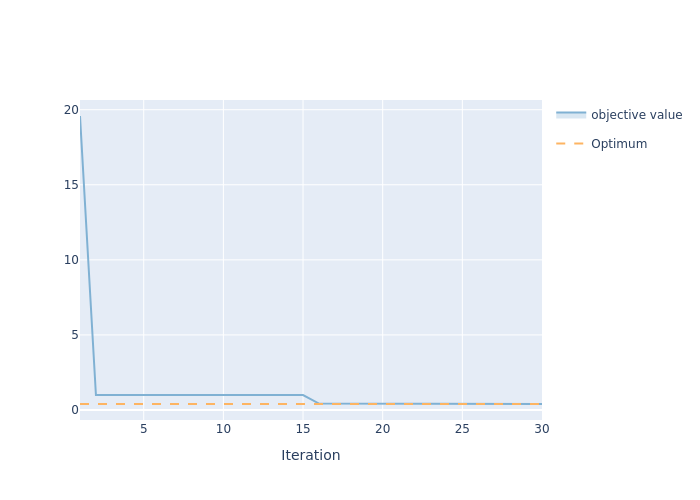

In [36]:
import numpy as np
from ax.plot.trace import optimization_trace_single_method


# `plot_single_method` expects a 2-d array of means, because it expects to average means from multiple
# optimization runs, so we wrap out best objectives array in another array.
objective_means = np.array([[trial.objective_mean for trial in exp.trials.values()]])
best_objective_plot = optimization_trace_single_method(
    y=np.minimum.accumulate(objective_means, axis=1),
    optimum=0.397887,  # Known minimum objective for Branin function.
)
render(best_objective_plot)